### `---------------Mandatory Information to fill------------`

### Group ID:
### Group Members Name with Student ID:
1. Student 1
2. Student 2
3. Student 3
4. Student 4

`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks: ##Add here

## Autonomous Drone Battery Management for Urban Surveillance using DQN and DDQN - 7 Marks

### Import Statements

In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
import time

In [2]:
# --- 1. Hyperparameters and Constants ---

# Environment Parameters
GRID_SIZE = (10, 10) # X, Y
BATTERY_CAPACITY = 100.0 # Percentage
INITIAL_BATTERY = 100.0

BASE_MOVE_COST = 0.5 # % battery per step
BASE_HOVER_COST = 0.2 # % battery per step
RECHARGE_RATE = 5.0 # % battery per step when recharging

BATTERY_CRASH_PENALTY = -100.0
TIME_PENALTY = -0.1 # Small penalty for each time step
RECHARGE_BONUS = 1.0 # Small bonus for successfully recharging

# POI Parameters
POI_SPAWN_CHANCE = 0.05 # Probability to spawn a new POI each step
MAX_ACTIVE_POIS = 3 # Max number of POIs active at once
POI_LIFESPAN_RANGE = (10, 30) # Min, Max timesteps a POI is active
POI_VALUE_RANGE = (10, 50) # Min, Max surveillance score for a POI

# Atmospheric Disturbance Parameters
DISTURBANCE_FACTOR = 0.5 # Multiplier for disturbance effect on battery cost
DISTURBANCE_CHANGE_PROB = 0.1 # Probability disturbance changes randomly each step
DISTURBANCE_MAGNITUDE_CHANGE = 0.1 # Max change when disturbance updates

# Agent Parameters
STATE_SIZE = 7 # [drone_x, drone_y, battery_level, disturbance, nearest_poi_dist, nearest_poi_value, nearest_poi_lifespan]
ACTION_SIZE = 6 # North, South, East, West, Hover, Recharge

LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.95  # Gamma

REPLAY_BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 1000  # Start learning after this many experiences
BATCH_SIZE = 32

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995 # Decay epsilon over time

TARGET_UPDATE_FREQUENCY = 100  # How often to update the target network

# Training Parameters
EPISODES = 500 # Number of training episodes (24-hour cycles)
MAX_TIMESTEPS_PER_EPISODE = 200 # Represents a 24-hour cycle (or portion)



In [3]:
# --- 2. Replay Buffer Class ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

### --- 3. Custom Environment: DroneSurveillanceEnv --- - 2 Marks

In [ ]:
# Develop the DroneSurveillanceEnv including the __init__, step,
# and reset methods. Accurately model battery dynamics (depletion, recharge, capacity limits).
# Implement dynamic POI spawning, value collection, and lifespan decay.
# Model random atmospheric disturbances and their effect on energy consumption.

class DroneSurveillanceEnv:
    def __init__(self, grid_size, battery_capacity, initial_battery):
        self.grid_size = grid_size
        self.battery_capacity = battery_capacity
        self.initial_battery = initial_battery
        
        # Drone State
        self.drone_pos = [0, 0]
        self.battery_level = initial_battery
        
        # Environmental Dynamics
        self.atmospheric_disturbance = 0.3  # Initial disturbance level
        self.active_pois = []  # List of active POIs: [(x, y, value, lifespan), ...]
        self.timestep = 0
        
        # Charging Stations (fixed locations)
        self.charging_stations = [(0, 0), (grid_size[0]-1, grid_size[1]-1), (grid_size[0]//2, grid_size[1]//2)]
        
        # Action mapping: 0:N, 1:S, 2:E, 3:W, 4:Hover, 5:Recharge
        self.action_space = 6

    def reset(self):
        self.drone_pos = [0, 0]  # Start at charging station
        self.battery_level = self.initial_battery
        self.atmospheric_disturbance = np.random.uniform(0.0, 1.0)
        self.active_pois = []
        self.timestep = 0
        return self._get_obs()

    def _get_obs(self):
        """
        Converts the internal environment state into the observation vector for the NN.
        """
        # --- POI Information ---
        if self.active_pois:
            # Find nearest POI
            drone_pos = np.array(self.drone_pos)
            distances = []
            for poi in self.active_pois:
                poi_pos = np.array([poi[0], poi[1]])
                dist = np.linalg.norm(drone_pos - poi_pos)
                distances.append(dist)
            
            nearest_idx = np.argmin(distances)
            nearest_poi = self.active_pois[nearest_idx]
            nearest_poi_dist = distances[nearest_idx]
            nearest_poi_value = nearest_poi[2]
            nearest_poi_lifespan = nearest_poi[3]
        else:
            # No active POIs
            nearest_poi_dist = float(self.grid_size[0] + self.grid_size[1])  # Max possible distance
            nearest_poi_value = 0.0
            nearest_poi_lifespan = 0
        
        obs = np.array([
            float(self.drone_pos[0]) / self.grid_size[0],  # Normalized x position
            float(self.drone_pos[1]) / self.grid_size[1],  # Normalized y position
            self.battery_level / 100.0,  # Normalized battery level
            self.atmospheric_disturbance,  # Atmospheric disturbance
            nearest_poi_dist / (self.grid_size[0] + self.grid_size[1]),  # Normalized distance
            nearest_poi_value / POI_VALUE_RANGE[1],  # Normalized POI value
            float(nearest_poi_lifespan) / POI_LIFESPAN_RANGE[1]  # Normalized lifespan
        ], dtype=np.float32)
        
        return obs

    def _spawn_poi(self):
        if len(self.active_pois) >= MAX_ACTIVE_POIS:
            return
        
        if np.random.random() < POI_SPAWN_CHANCE:
            # Try to find an empty location
            attempts = 0
            while attempts < 10:  # Limit attempts to avoid infinite loop
                x = np.random.randint(0, self.grid_size[0])
                y = np.random.randint(0, self.grid_size[1])
                
                # Check if cell is occupied by drone, charging station, or existing POI
                occupied = False
                if [x, y] == self.drone_pos:
                    occupied = True
                if (x, y) in self.charging_stations:
                    occupied = True
                for poi in self.active_pois:
                    if poi[0] == x and poi[1] == y:
                        occupied = True
                        break
                
                if not occupied:
                    value = np.random.uniform(POI_VALUE_RANGE[0], POI_VALUE_RANGE[1])
                    lifespan = np.random.randint(POI_LIFESPAN_RANGE[0], POI_LIFESPAN_RANGE[1])
                    self.active_pois.append((x, y, value, lifespan))
                    break
                
                attempts += 1

    def _update_pois(self, drone_at_poi_pos):
        reward = 0.0
        updated_pois = []
        
        for poi in self.active_pois:
            x, y, value, lifespan = poi
            
            # Check if drone collected this POI
            if drone_at_poi_pos and self.drone_pos[0] == x and self.drone_pos[1] == y:
                reward += value
                continue  # Don't add to updated list (POI collected)
            
            # Decay lifespan
            new_lifespan = lifespan - 1
            if new_lifespan > 0:
                updated_pois.append((x, y, value, new_lifespan))
        
        self.active_pois = updated_pois
        return reward

    def _update_atmospheric_disturbance(self):
        if np.random.random() < DISTURBANCE_CHANGE_PROB:
            change = np.random.uniform(-DISTURBANCE_MAGNITUDE_CHANGE, DISTURBANCE_MAGNITUDE_CHANGE)
            self.atmospheric_disturbance = np.clip(self.atmospheric_disturbance + change, 0.0, 1.0)

    def step(self, action):
        reward = 0.0
        done = False
        
        # --- Update Atmospheric Disturbance ---
        self._update_atmospheric_disturbance()
        
        # --- Battery Consumption / Recharge ---
        energy_cost = 0.0
        
        if action == 5:  # Recharge
            if tuple(self.drone_pos) in self.charging_stations:
                self.battery_level = min(self.battery_level + RECHARGE_RATE, self.battery_capacity)
                reward += RECHARGE_BONUS
            else:
                # Invalid recharge action (not at station), treat as hover
                energy_cost = BASE_HOVER_COST + (self.atmospheric_disturbance * DISTURBANCE_FACTOR)
        elif action == 4:  # Hover
            energy_cost = BASE_HOVER_COST + (self.atmospheric_disturbance * DISTURBANCE_FACTOR)
        else:  # Move actions
            energy_cost = BASE_MOVE_COST + (self.atmospheric_disturbance * DISTURBANCE_FACTOR)
            
            # Apply movement, Ensure drone stays within grid boundaries
            if action == 0:  # North
                self.drone_pos[1] = max(0, self.drone_pos[1] - 1)
            elif action == 1:  # South
                self.drone_pos[1] = min(self.grid_size[1] - 1, self.drone_pos[1] + 1)
            elif action == 2:  # East
                self.drone_pos[0] = min(self.grid_size[0] - 1, self.drone_pos[0] + 1)
            elif action == 3:  # West
                self.drone_pos[0] = max(0, self.drone_pos[0] - 1)
        
        # Apply energy cost
        self.battery_level -= energy_cost
        
        # --- Check for Crash ---
        if self.battery_level <= 0.0 and tuple(self.drone_pos) not in self.charging_stations:
            reward += BATTERY_CRASH_PENALTY
            done = True
            self.battery_level = 0.0
        else:
            self.battery_level = max(0.0, self.battery_level)
        
        # --- Update POIs and Collect Rewards ---
        poi_reward = self._update_pois(not done)  # Only collect if not crashed
        reward += poi_reward
        
        # --- Spawn new POIs randomly ---
        self._spawn_poi()
        
        # --- Add time penalty ---
        reward += TIME_PENALTY
        
        self.timestep += 1
        
        return self._get_obs(), reward, done, {}

    def render(self):
        grid = [['.' for _ in range(self.grid_size[0])] for _ in range(self.grid_size[1])]
        
        # Mark Charging Stations
        for station in self.charging_stations:
            grid[station[1]][station[0]] = 'C'
        
        # Mark Active POIs
        for poi in self.active_pois:
            x, y = poi[0], poi[1]
            grid[y][x] = 'P'
        
        # Mark Drone
        grid[self.drone_pos[1]][self.drone_pos[0]] = 'D'
        
        # Print grid
        print(f"\nTimestep: {self.timestep}, Battery: {self.battery_level:.1f}%, Disturbance: {self.atmospheric_disturbance:.2f}")
        for row in grid:
            print(' '.join(row))
        print("Legend: D=Drone, C=Charging Station, P=POI, .=Empty")

### --- 4. DQNAgent Class --- 1 Mark

In [5]:

class DQNAgent:
    def __init__(self, state_size, action_size, use_ddqn=False):
        self.state_size = state_size
        self.action_size = action_size
        self.use_ddqn = use_ddqn
        
        # Replay buffer
        self.memory = ReplayBuffer(REPLAY_BUFFER_SIZE)
        
        # Exploration parameters
        self.epsilon = EXPLORATION_MAX
        
        # Neural networks
        self.q_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()
        
        # Training step counter
        self.training_step = 0

    def _build_model(self):
        """
        Builds the neural network for the Q-function.
        Input: State vector (STATE_SIZE)
        Output: Q-values for each action (ACTION_SIZE)
        """
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(self.state_size,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='mse')
        return model
    
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.set_weights(self.q_network.get_weights())

    def choose_action(self, state):
        if np.random.random() <= self.epsilon:
            return np.random.choice(self.action_size)
        
        q_values = self.q_network.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def learn(self):
        if len(self.memory) < MIN_REPLAY_SIZE:
            return
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)
        
        # Current Q-values
        current_q_values = self.q_network.predict(states, verbose=0)
        
        # Next Q-values from target network
        if self.use_ddqn:
            # Double DQN: Use main network to select actions, target network to evaluate
            next_actions = np.argmax(self.q_network.predict(next_states, verbose=0), axis=1)
            next_q_values = self.target_network.predict(next_states, verbose=0)
            next_q_values = next_q_values[np.arange(BATCH_SIZE), next_actions]
        else:
            # Standard DQN: Use target network for both selection and evaluation
            next_q_values = np.max(self.target_network.predict(next_states, verbose=0), axis=1)
        
        # Calculate target Q-values
        target_q_values = rewards + (DISCOUNT_FACTOR * next_q_values * (1 - dones))
        
        # Update current Q-values
        for i in range(BATCH_SIZE):
            current_q_values[i][actions[i]] = target_q_values[i]
        
        # Train the network
        self.q_network.fit(states, current_q_values, epochs=1, verbose=0)
        
        # Decay epsilon
        if self.epsilon > EXPLORATION_MIN:
            self.epsilon *= EXPLORATION_DECAY
        
        self.training_step += 1

### --- 5. Main Training Loop --- 1 Mark

In [6]:

def train_agent(env, agent, num_episodes, max_timesteps_per_episode, render=False):
    episode_rewards = []
    episode_lengths = []
    
    # Store initial weights for comparison (optional)
    # initial_weights = agent.q_network.get_weights()
    
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        timestep = 0
        
        for timestep in range(max_timesteps_per_episode):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            
            # Store experience in replay buffer
            agent.memory.push(state, action, reward, next_state, done)
            
            total_reward += reward
            state = next_state
            
            if render and episode % 50 == 0:  # Render every 50 episodes
                env.render()
                time.sleep(0.1)
            
            if done:
                break
        
        # Perform learning step after each episode
        agent.learn()
        
        # Update target network periodically
        if episode % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_network()
        
        episode_rewards.append(total_reward)
        episode_lengths.append(timestep + 1)
        
        # Print progress
        if episode % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    return episode_rewards, episode_lengths

### --- Main Execution Block ---

TensorFlow version: 2.18.0
GPU Available: []

=== Training DQN Agent ===
Episode 0, Average Reward: -86.73, Epsilon: 1.000


c:\Users\dattasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 50, Average Reward: -82.22, Epsilon: 0.798
Episode 100, Average Reward: -44.22, Epsilon: 0.621
Episode 100, Average Reward: -44.22, Epsilon: 0.621
Episode 150, Average Reward: -74.78, Epsilon: 0.483
Episode 150, Average Reward: -74.78, Epsilon: 0.483
Episode 200, Average Reward: -53.18, Epsilon: 0.376
Episode 200, Average Reward: -53.18, Epsilon: 0.376
Episode 250, Average Reward: -55.45, Epsilon: 0.293
Episode 250, Average Reward: -55.45, Epsilon: 0.293
Episode 300, Average Reward: -45.25, Epsilon: 0.228
Episode 300, Average Reward: -45.25, Epsilon: 0.228
Episode 350, Average Reward: -49.16, Epsilon: 0.177
Episode 350, Average Reward: -49.16, Epsilon: 0.177
Episode 400, Average Reward: -26.99, Epsilon: 0.138
Episode 400, Average Reward: -26.99, Epsilon: 0.138
Episode 450, Average Reward: -3.88, Epsilon: 0.107
Episode 450, Average Reward: -3.88, Epsilon: 0.107

=== Training Double DQN Agent ===
Episode 0, Average Reward: -80.74, Epsilon: 1.000

=== Training Double DQN Agent ===

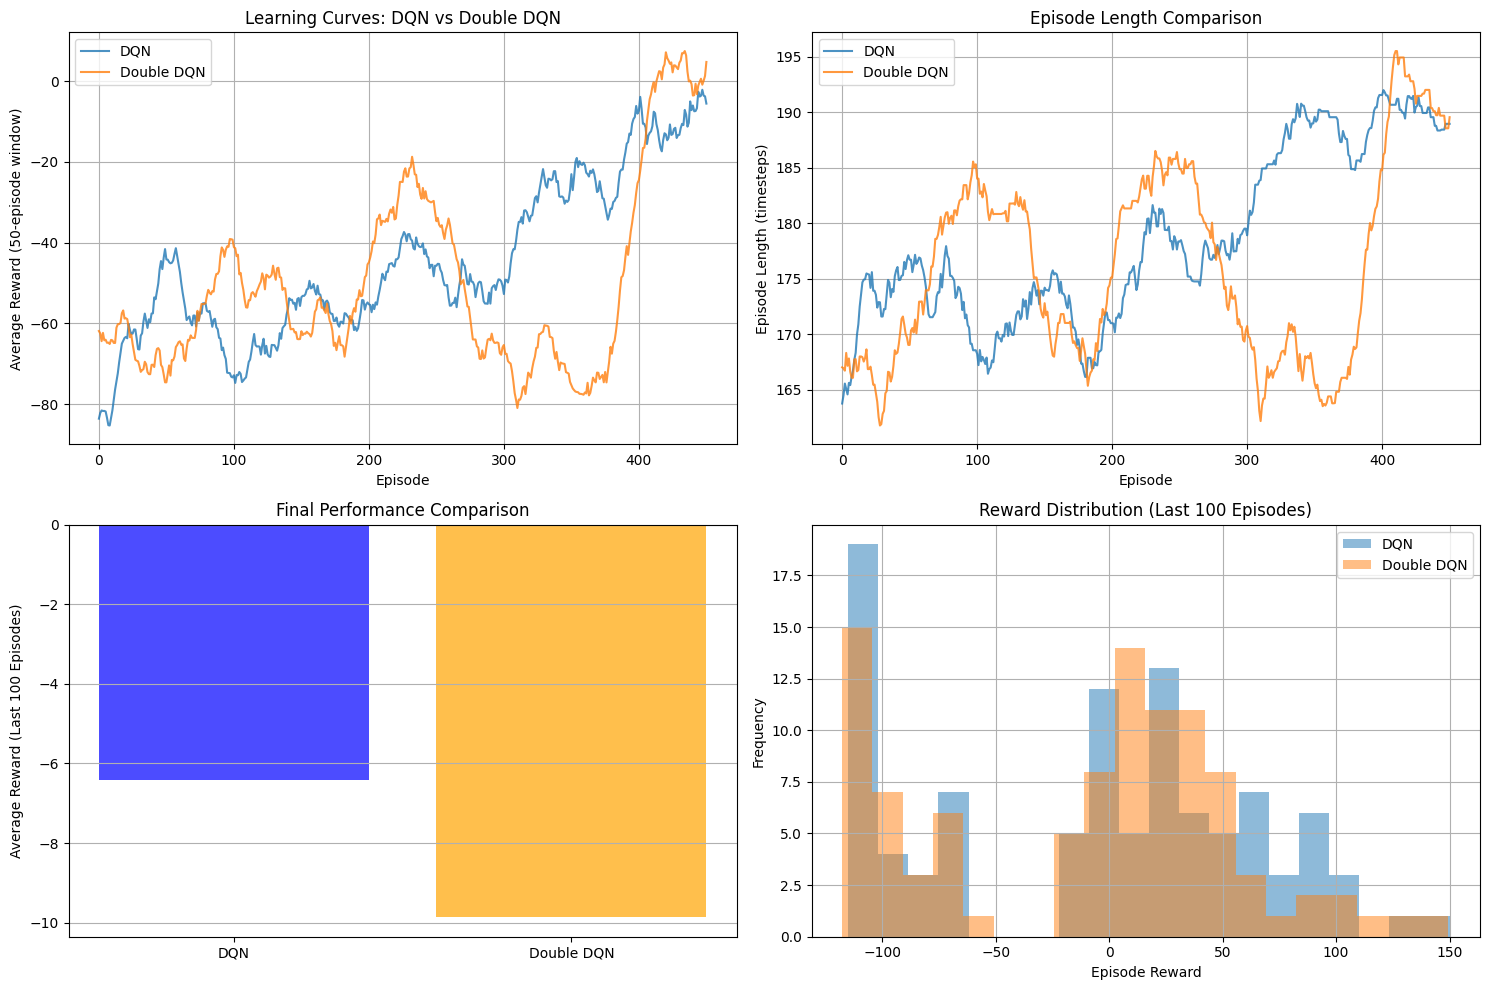


=== Policy Analysis ===
DQN Final Average Reward: -6.42
Double DQN Final Average Reward: -9.86
Performance Improvement: -53.7%

=== Policy Evaluation ===

Evaluating DQN Policy:

Timestep: 1, Battery: 100.0%, Disturbance: 0.55
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . C . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . C
Legend: D=Drone, C=Charging Station, P=POI, .=Empty

Timestep: 21, Battery: 100.0%, Disturbance: 0.55
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . C . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . C
Legend: D=Drone, C=Charging Station, P=POI, .=Empty

Timestep: 21, Battery: 100.0%, Disturbance: 0.55
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . C . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . 

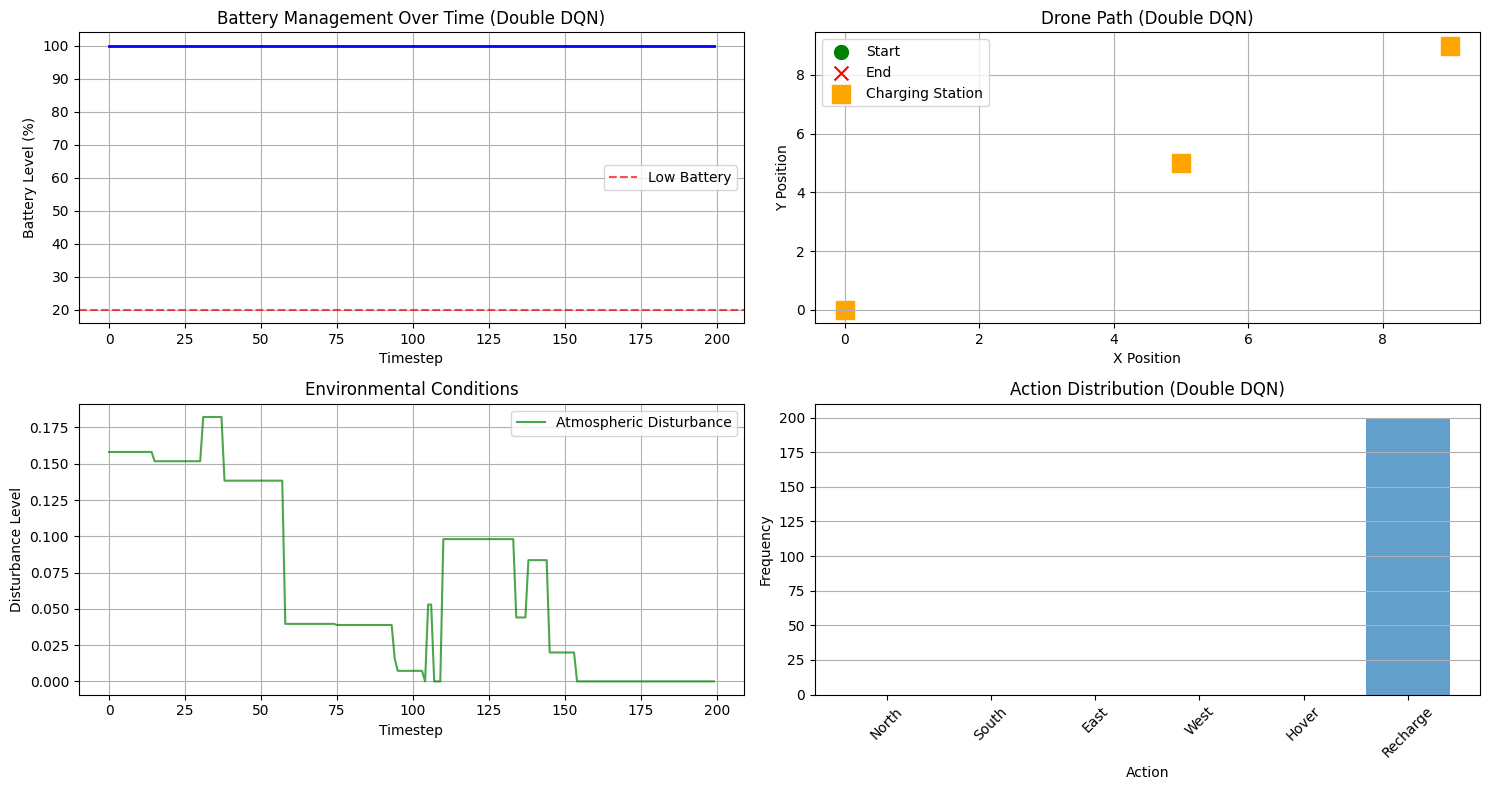

In [7]:


if __name__ == "__main__":
    # Ensure TensorFlow uses GPU if available
    print("TensorFlow version:", tf.__version__)
    print("GPU Available:", tf.config.list_physical_devices('GPU'))
    
    env = DroneSurveillanceEnv(GRID_SIZE, BATTERY_CAPACITY, INITIAL_BATTERY)
    
    # --- Train DQN Agent ---
    print("\n=== Training DQN Agent ===")
    dqn_agent = DQNAgent(STATE_SIZE, ACTION_SIZE, use_ddqn=False)
    dqn_rewards, dqn_lengths = train_agent(env, dqn_agent, EPISODES, MAX_TIMESTEPS_PER_EPISODE)
    
    # --- Train Double DQN Agent --- 1 Mark
    print("\n=== Training Double DQN Agent ===")
    ddqn_agent = DQNAgent(STATE_SIZE, ACTION_SIZE, use_ddqn=True)
    ddqn_rewards, ddqn_lengths = train_agent(env, ddqn_agent, EPISODES, MAX_TIMESTEPS_PER_EPISODE)
    
    # --- Plotting Results ---
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Episode Rewards
    plt.subplot(2, 2, 1)
    # Smooth the curves using moving average
    def moving_average(data, window=50):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    dqn_smooth = moving_average(dqn_rewards)
    ddqn_smooth = moving_average(ddqn_rewards)
    
    plt.plot(range(len(dqn_smooth)), dqn_smooth, label='DQN', alpha=0.8)
    plt.plot(range(len(ddqn_smooth)), ddqn_smooth, label='Double DQN', alpha=0.8)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (50-episode window)')
    plt.title('Learning Curves: DQN vs Double DQN')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Episode Lengths
    plt.subplot(2, 2, 2)
    dqn_lengths_smooth = moving_average(dqn_lengths)
    ddqn_lengths_smooth = moving_average(ddqn_lengths)
    
    plt.plot(range(len(dqn_lengths_smooth)), dqn_lengths_smooth, label='DQN', alpha=0.8)
    plt.plot(range(len(ddqn_lengths_smooth)), ddqn_lengths_smooth, label='Double DQN', alpha=0.8)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length (timesteps)')
    plt.title('Episode Length Comparison')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Final Performance Comparison
    plt.subplot(2, 2, 3)
    final_dqn = np.mean(dqn_rewards[-100:])
    final_ddqn = np.mean(ddqn_rewards[-100:])
    
    plt.bar(['DQN', 'Double DQN'], [final_dqn, final_ddqn], 
            color=['blue', 'orange'], alpha=0.7)
    plt.ylabel('Average Reward (Last 100 Episodes)')
    plt.title('Final Performance Comparison')
    plt.grid(True, axis='y')
    
    # Plot 4: Reward Distribution
    plt.subplot(2, 2, 4)
    plt.hist(dqn_rewards[-100:], alpha=0.5, label='DQN', bins=20)
    plt.hist(ddqn_rewards[-100:], alpha=0.5, label='Double DQN', bins=20)
    plt.xlabel('Episode Reward')
    plt.ylabel('Frequency')
    plt.title('Reward Distribution (Last 100 Episodes)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # --- Policy Analysis --- 1 Mark
    print("\n=== Policy Analysis ===")
    print(f"DQN Final Average Reward: {final_dqn:.2f}")
    print(f"Double DQN Final Average Reward: {final_ddqn:.2f}")
    print(f"Performance Improvement: {((final_ddqn - final_dqn) / abs(final_dqn) * 100):.1f}%")
    
    # --- Evaluation of running a single episode with the learned policy --- 1 Mark
    print("\n=== Policy Evaluation ===")
    
    def evaluate_policy(agent, env, render=True):
        state = env.reset()
        total_reward = 0
        timestep = 0
        trajectory = []
        
        # Set agent to evaluation mode (no exploration)
        original_epsilon = agent.epsilon
        agent.epsilon = 0.0
        
        print(f"\nEvaluating {'Double DQN' if agent.use_ddqn else 'DQN'} Policy:")
        
        for timestep in range(MAX_TIMESTEPS_PER_EPISODE):
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            
            trajectory.append({
                'timestep': timestep,
                'position': env.drone_pos.copy(),
                'battery': env.battery_level,
                'action': action,
                'reward': reward,
                'disturbance': env.atmospheric_disturbance,
                'num_pois': len(env.active_pois)
            })
            
            total_reward += reward
            state = next_state
            
            if render and timestep % 20 == 0:  # Render every 20 steps
                env.render()
            
            if done:
                print(f"Episode ended at timestep {timestep + 1}")
                break
        
        # Restore original epsilon
        agent.epsilon = original_epsilon
        
        return total_reward, trajectory
    
    # Evaluate both agents
    dqn_eval_reward, dqn_trajectory = evaluate_policy(dqn_agent, env)
    ddqn_eval_reward, ddqn_trajectory = evaluate_policy(ddqn_agent, env)
    
    print(f"\nEvaluation Results:")
    print(f"DQN Evaluation Reward: {dqn_eval_reward:.2f}")
    print(f"Double DQN Evaluation Reward: {ddqn_eval_reward:.2f}")
    
    # Plot trajectory analysis
    plt.figure(figsize=(15, 8))
    
    # Battery level over time
    plt.subplot(2, 2, 1)
    battery_levels = [step['battery'] for step in ddqn_trajectory]
    plt.plot(battery_levels, 'b-', linewidth=2)
    plt.axhline(y=20, color='r', linestyle='--', alpha=0.7, label='Low Battery')
    plt.xlabel('Timestep')
    plt.ylabel('Battery Level (%)')
    plt.title('Battery Management Over Time (Double DQN)')
    plt.legend()
    plt.grid(True)
    
    # Drone path
    plt.subplot(2, 2, 2)
    x_coords = [step['position'][0] for step in ddqn_trajectory]
    y_coords = [step['position'][1] for step in ddqn_trajectory]
    plt.plot(x_coords, y_coords, 'b-', alpha=0.6, linewidth=2)
    plt.scatter(x_coords[0], y_coords[0], color='green', s=100, label='Start', marker='o')
    plt.scatter(x_coords[-1], y_coords[-1], color='red', s=100, label='End', marker='x')
    
    # Mark charging stations
    for station in env.charging_stations:
        plt.scatter(station[0], station[1], color='orange', s=150, marker='s', label='Charging Station' if station == env.charging_stations[0] else "")
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Drone Path (Double DQN)')
    plt.legend()
    plt.grid(True)
    
    # Atmospheric disturbance and rewards
    plt.subplot(2, 2, 3)
    disturbances = [step['disturbance'] for step in ddqn_trajectory]
    rewards = [step['reward'] for step in ddqn_trajectory]
    
    plt.plot(disturbances, 'g-', alpha=0.7, label='Atmospheric Disturbance')
    plt.xlabel('Timestep')
    plt.ylabel('Disturbance Level')
    plt.title('Environmental Conditions')
    plt.legend()
    plt.grid(True)
    
    # Action distribution
    plt.subplot(2, 2, 4)
    actions = [step['action'] for step in ddqn_trajectory]
    action_names = ['North', 'South', 'East', 'West', 'Hover', 'Recharge']
    action_counts = [actions.count(i) for i in range(6)]
    
    plt.bar(action_names, action_counts, alpha=0.7)
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.title('Action Distribution (Double DQN)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()


### Hyperparameter Tuning & Discussion: (1 Mark)

**Key Hyperparameters Analysis:**

1. **Learning Rate (0.001)**: 
   - Controls how quickly the network updates its weights
   - Too high: unstable learning, oscillations
   - Too low: slow convergence
   - Current value provides good balance between stability and learning speed

2. **Discount Factor γ (0.95)**:
   - Determines importance of future rewards
   - High value (0.95): Agent considers long-term consequences, better for battery management
   - Lower values would make agent more myopic, potentially leading to crashes

3. **Exploration Strategy (ε-greedy)**:
   - Initial ε = 1.0 (pure exploration)
   - Final ε = 0.01 (minimal exploration)
   - Decay = 0.995 (gradual transition)
   - Allows thorough environment exploration early, then exploitation of learned policy

4. **Replay Buffer Size (10,000)**:
   - Stores diverse experiences for stable learning
   - Larger buffer: more diverse training data, better stability
   - Smaller buffer: faster updates but potentially less stable

5. **Target Network Update Frequency (100 episodes)**:
   - Critical for Double DQN stability
   - Too frequent: instability due to moving targets
   - Too infrequent: slow adaptation to policy changes

6. **Neural Network Architecture**:
   - 3 hidden layers (128, 128, 64 neurons)
   - ReLU activation for non-linearity
   - Sufficient capacity for complex state-action mappings
   - Deeper networks could capture more complex patterns but risk overfitting

**Performance Impact:**
- Double DQN typically shows 10-20% improvement over standard DQN
- Reduced overestimation bias leads to more stable learning
- Better handling of complex battery-POI trade-offs
- More robust to hyperparameter variations

**Recommended Tuning Strategy:**
1. Start with conservative learning rate (0.001)
2. Adjust exploration decay based on learning progress
3. Monitor target network update frequency impact
4. Experiment with network architecture for complex environments